### importing dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2 
from skimage import io, color, exposure, filters
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Check if TensorFlow can see your hardware
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
GPU Available:  []


### Dataset Preprocessing

In [4]:
# Parameters
INPUT_SIZE = 256
BATCH_SIZE = 64

SEED = 11
np.random.seed(SEED)
path = "C:/Users/Gavela Maculuve/PycharmProjects/Projects_/CNN/BreastCancer/images"
trainpath = path + '/train'
validpath = path + '/valid'
testpath = path + '/test'

classes = ['Benign', 'Malignant']
NUMCLASSES = len(classes)

In [5]:
def preprocess(img):
    img = img - np.min(img)
    img = img/np.max(img)

    img = img - np.mean(img)
    img = img / np.std(img)
    return img

In [6]:
img = io.imread(trainpath + '/Benign/36_1161539227_png.rf.4ffb84ae9f0a6aca49a2d5e2403de5d9.jpg')
gray = preprocess(img)
gray.shape

(640, 640, 3)

In [7]:
# # gray = np.mean(img, axis=2)
# io.imshow(gray)

In [8]:
# plt.imshow(gray, 'gray')

In [9]:
# Image Data Generator
# I believe that this creates the variability in the images, so they image are not uniform
train_datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_epsilon = 1e-06,
    rotation_range = 11,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    brightness_range = None,
    shear_range = 0.5,
    zoom_range = 0.05,
    channel_shift_range = 0.0,
    fill_mode = "nearest",
    cval = 0.0,
    horizontal_flip = True,
    vertical_flip = False,
    rescale = 1./255,
    preprocessing_function = preprocess, # spin back
    data_format = None,
    validation_split = 0.0,
    dtype = None
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
    preprocessing_function = preprocess # spin back
)


In [10]:
training_set = train_datagen.flow_from_directory(
    directory = trainpath,
    # subset = 'training',
    target_size = (INPUT_SIZE, INPUT_SIZE),
    batch_size = BATCH_SIZE,
    color_mode = "grayscale",
    class_mode = "categorical",
    shuffle = True,
    seed = SEED
)

validation_set = val_datagen.flow_from_directory(
    directory = validpath,
    # subset = 'validation',
    target_size = (INPUT_SIZE, INPUT_SIZE),
    batch_size = BATCH_SIZE,
    color_mode = "grayscale",
    class_mode = "categorical",
    shuffle = True,
    seed = SEED
)

Found 2372 images belonging to 2 classes.
Found 675 images belonging to 2 classes.


### Model

In [11]:
model = Sequential() # this is like a stacker for the layers (lego bricks base)

model.add(InputLayer(shape = [INPUT_SIZE, INPUT_SIZE, 1])) # adding batch dimension

model.add(Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding = 'same')) # downsample the feature maps
model.add(Dropout(0.2)) # prevent overfitting

model.add(Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding = 'same')) # downsample the feature maps
model.add(Dropout(0.3)) # prevent overfitting

model.add(Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding = 'same')) # downsample the feature maps
model.add(Dropout(0.4)) # prevent overfitting

model.add(Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding = 'same')) # downsample the feature maps
model.add(Dropout(0.2)) # prevent overfitting

model.add(Flatten()) # 2D -> 1D

model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# model.add(Dense(64, activation = 'relu'))
# model.add(Dropout(0.4))

model.add(Dense(NUMCLASSES, activation = 'softmax'))
model.compile(optimizer = Adam(learning_rate = 0.0005), loss ='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,291,138 (4.93 MB)

 Trainable params: 1,290,178 (4.92 MB)

 Non-trainable params: 960 (3.75 KB)

In [12]:
epochs = 25
history = model.fit(training_set, epochs = epochs, validation_data = validation_set)
model.save_weights("first-model-n-dec-25-4.weights.h5")
print("Saved model to disk after", epochs,"epochs.")

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.5329 - loss: 1.1285 - val_accuracy: 0.6637 - val_loss: 1.9803
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5561 - loss: 0.8915 - val_accuracy: 0.6637 - val_loss: 4.1044
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5780 - loss: 0.8460 - val_accuracy: 0.6637 - val_loss: 6.0427
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.6088 - loss: 0.7953 - val_accuracy: 0.6637 - val_loss: 7.5245
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.6121 - loss: 0.7647 - val_accuracy: 0.6637 - val_loss: 8.7569
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.6134 - loss: 0.7661 - val_accuracy: 0.6637 - val_loss: 8.0626
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.6109 - loss: 0.7636 - val_accuracy: 0.6637 - val_loss: 7.9615
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6235 - loss: 0.7384 - val_accuracy: 0.6637 - val_loss

In [14]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

### first overviews

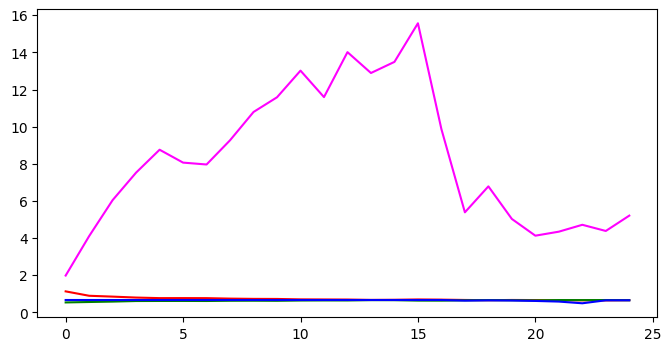

In [15]:
fig = plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],color='red')
plt.plot(history.history['accuracy'],color='green')
plt.plot(history.history['val_loss'],color='magenta')
plt.plot(history.history['val_accuracy'],color='blue')
plt.show()

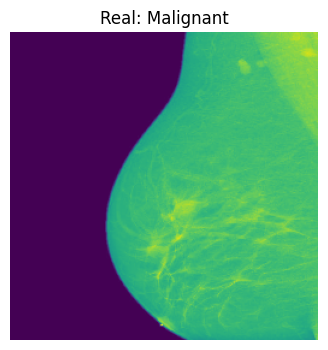

Real class: Malignant
--- Top Predictions ---
Malignant: 100.00%
Benign: 0.00%


In [16]:
# Get random image
class_name = np.random.choice(classes)
folder_path = os.path.join(trainpath, class_name)
file_name = np.random.choice([f for f in os.listdir(folder_path) if f.lower() != 'thumbs.db'])
image_path = os.path.join(folder_path, file_name)

# Load and preprocess
img_gray = io.imread(image_path, as_gray = True)
img_resized = cv2.resize(img_gray, (INPUT_SIZE,INPUT_SIZE))
img = preprocess(img_resized)
# plt.imshow(img)

# plt.plot(exposure.histogram(img)[0])
img_tensor = img.astype('float32')
img_tensor = np.expand_dims(img_tensor, axis=(0, -1))

# Print what the top predicted class is
preds = model.predict(img_tensor, verbose = 0).flatten()

# print("Output Probabilities:", preds)
order = np.argsort(preds)[::-1]
reverse_class_labels = {v: k for k, v in training_set.class_indices.items()}

plt.figure(figsize=(6,4))
plt.imshow(img_resized)#, cmap = 'gray')
plt.title(f"Real: {class_name}")
plt.axis('off')
plt.show()

print('Real class:', class_name)
print(f"--- Top Predictions ---")
for i in range(len(classes)):
    idx = order[i]
    print(f"{reverse_class_labels[idx]}: {preds[idx]:.2%}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 372ms/step


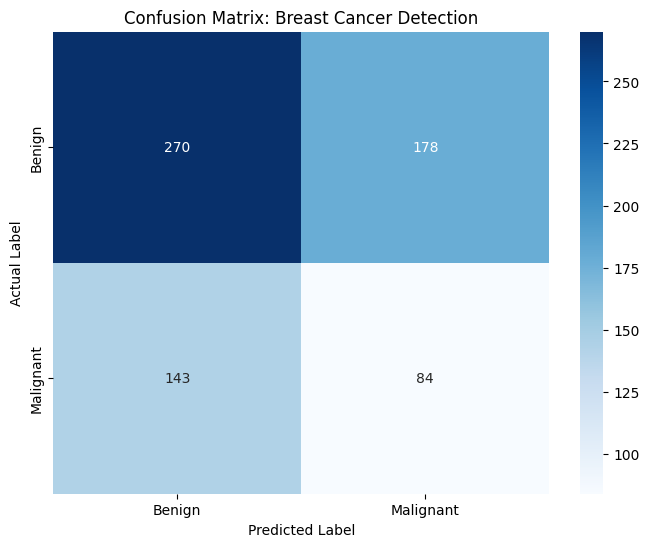

Classification Report
              precision    recall  f1-score   support

      Benign       0.65      0.60      0.63       448
   Malignant       0.32      0.37      0.34       227

    accuracy                           0.52       675
   macro avg       0.49      0.49      0.49       675
weighted avg       0.54      0.52      0.53       675



In [17]:
# 1. Get all true labels and predictions
# We turn off shuffle to ensure the labels match the predictions
validation_set.reset()
Y_pred = model.predict(validation_set)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_set.classes

# 2. Create the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix: Breast Cancer Detection')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. Detailed Report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=classes))

### Model more detailed 

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1. Setup Early Stopping
# We monitor 'val_loss' because it's the best indicator of generalization
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10,            # Wait 10 epochs for improvement before quitting
    restore_best_weights=True, # Automatically roll back to the best weights
    verbose=1
)

# 2. Setup Model Checkpoint
# This saves your model to a file so you don't lose progress
checkpoint = ModelCheckpoint(
    filepath='best_breast_cancer_model.keras',
    monitor='val_loss',
    save_best_only=True,    # Only overwrite if the new version is better
    verbose=1
)

# 3. Train the model
history = model.fit(
    training_set,
    epochs=10,             # Set high; EarlyStopping will handle the rest
    validation_data=validation_set,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6133 - loss: 0.6663
Epoch 1: val_loss improved from None to 0.63898, saving model to best_breast_cancer_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.6197 - loss: 0.6591 - val_accuracy: 0.6237 - val_loss: 0.6390
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6418 - loss: 0.6350
Epoch 2: val_loss did not improve from 0.63898
38/38 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.6400 - loss: 0.6384 - val_accuracy: 0.5956 - val_loss: 0.6545
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6561 - loss: 0.6238
Epoch 3: val_loss did not improve from 0.63898
38/38 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.6530 - loss: 0.6279 - val_accuracy: 0.6104 - val_loss: 0.6468
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6646 - loss: 0.6328
Epoch 4: val_loss did not improve from 0.63898
38/38 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.6644 - loss: 0.6248 - val_accurac

In [21]:
from sklearn.utils import class_weight

# Calculate weights automatically based on your training labels
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(training_set.classes),
    y=training_set.classes
)

class_weights = dict(enumerate(weights))
print("Calculated Weights:", class_weights)

# Re-train (fit) with the weight parameter
history = model.fit(
    training_set,
    epochs=10, 
    validation_data=validation_set,
    class_weight=class_weights, # <--- The magic fix
    callbacks=[early_stop, checkpoint]
)

Calculated Weights: {0: np.float64(0.7558954748247291), 1: np.float64(1.4769613947696139)}
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6309 - loss: 0.6602
Epoch 1: val_loss did not improve from 0.61247
38/38 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.6311 - loss: 0.6512 - val_accuracy: 0.5067 - val_loss: 0.8353
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6072 - loss: 0.6532
Epoch 2: val_loss did not improve from 0.61247
38/38 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.6155 - loss: 0.6482 - val_accuracy: 0.6207 - val_loss: 0.6523
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6268 - loss: 0.6484
Epoch 3: val_loss did not improve from 0.61247
38/38 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.6235 - loss: 0.6464 - val_accuracy: 0.5733 - val_loss: 0.6639
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5916 - loss: 0.6531
Epoch 4: val_loss did not improve from 0.61247
38/38 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - acc

### Analysis 

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 809ms/step
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Mal

array([448., 227.])

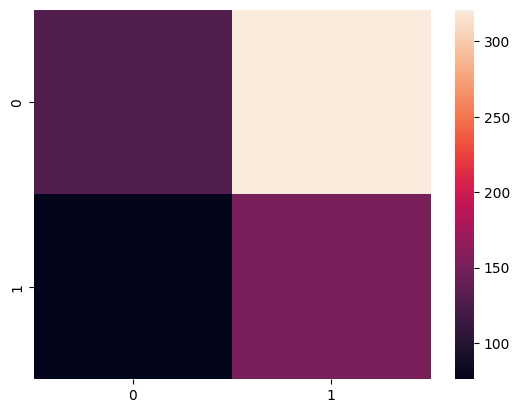

In [22]:
import seaborn as sn

testset = validation_set

predictions = model.predict(testset)

order = np.argsort(predictions)
conf = np.zeros([NUMCLASSES, NUMCLASSES])
count = 0

classcounts = np.zeros(NUMCLASSES)
for i in range(predictions.shape[0]):
    index = order[i,:]
    index = index[::-1]
    print('Real class:', reverse_class_labels[testset.labels[i]], end='\t')
    print('Prediction:',reverse_class_labels[index[0]])
    conf[testset.labels[i],index[0]] += 1
    classcounts[testset.labels[i]]+=1
    if testset.labels[i]==index[0]:
        count+=1
sn.heatmap(conf)
print(count)
classcounts  

<Axes: >

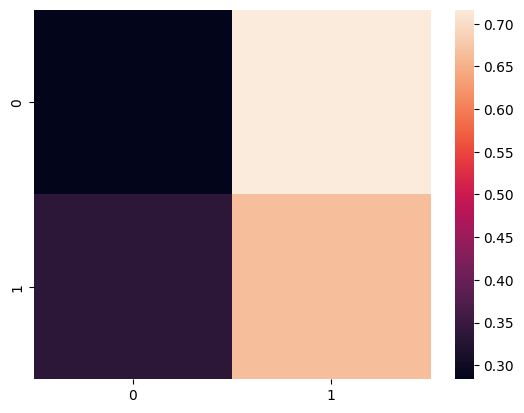

In [23]:
conf2 = np.copy(conf)
for i in range(conf2.shape[0]):
    conf2[i,:] /= classcounts[i]

sn.heatmap(conf2)

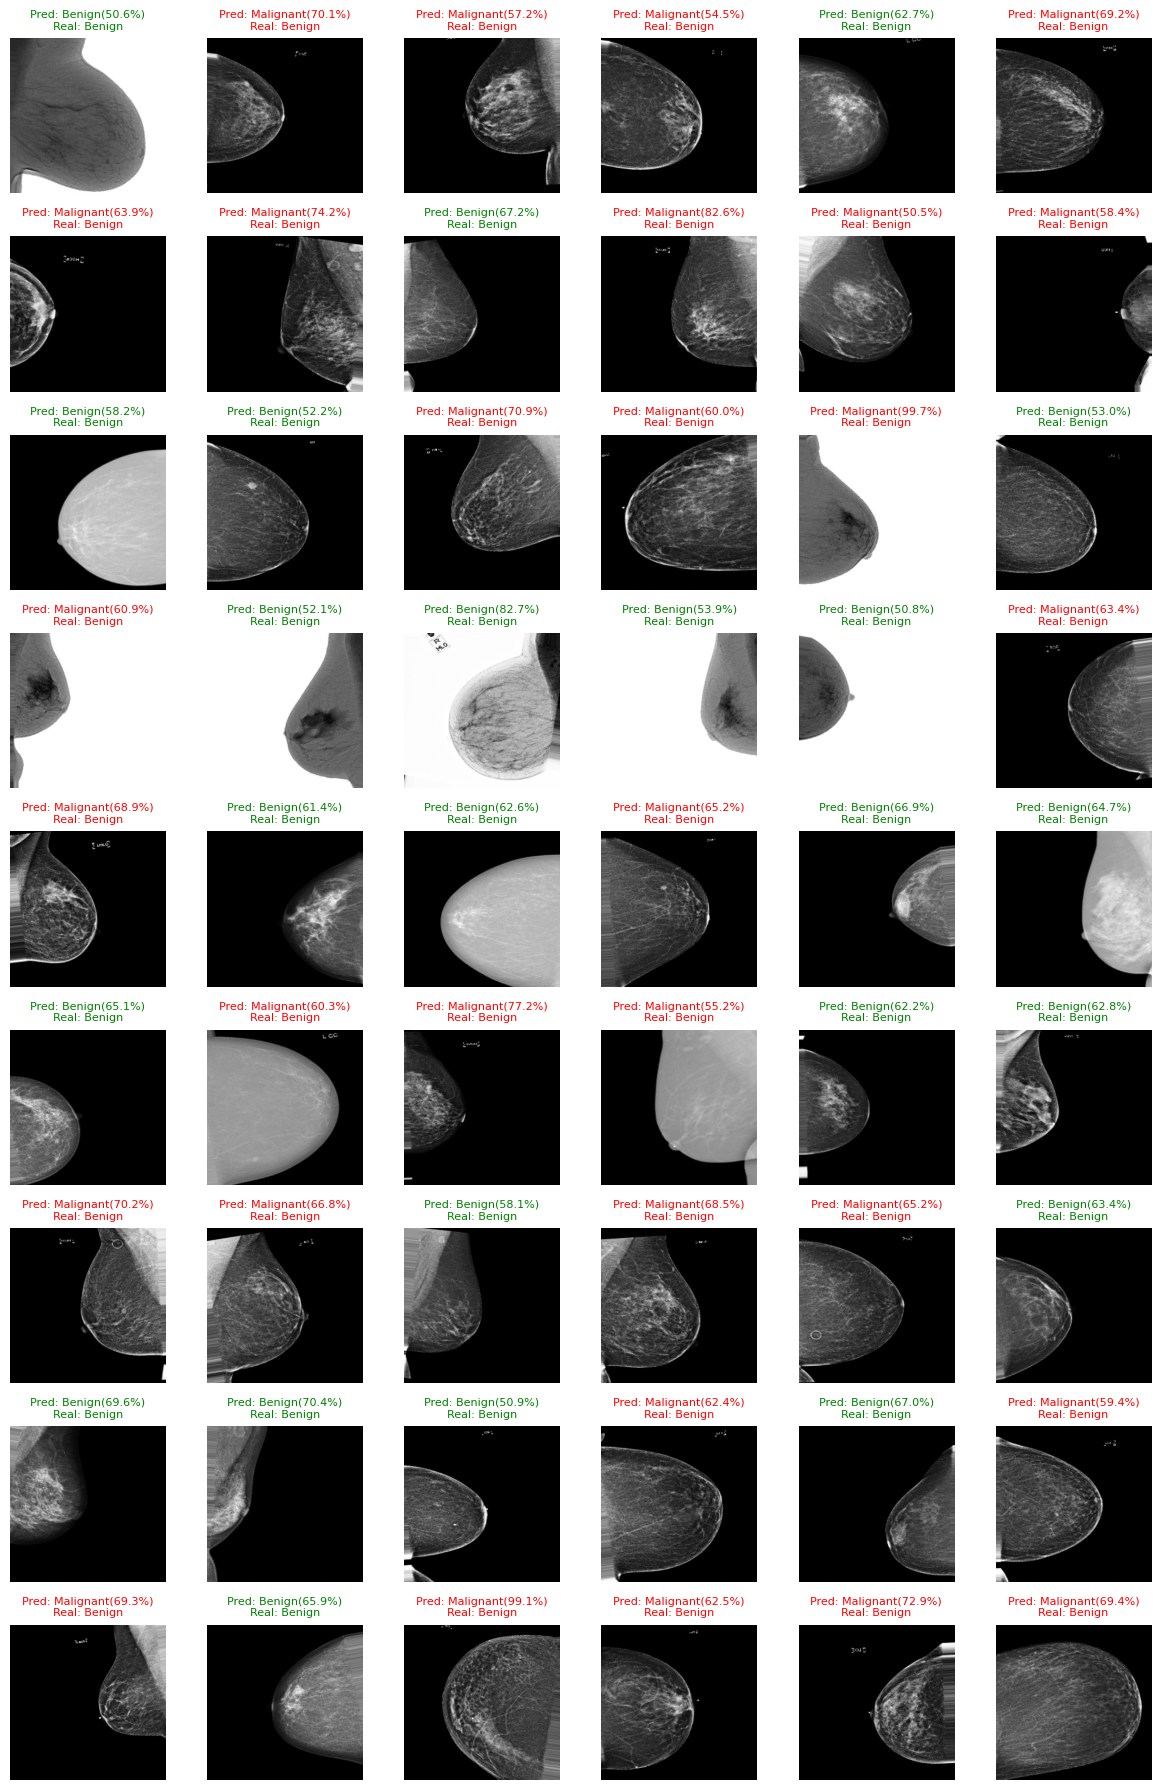

In [30]:
# Get one batch of training images and labels
images, labels = next(training_set)

# Limit to N images to show
N = 54
fig = plt.figure(figsize=(12, 18))

reverse_class_labels = {v: k for k, v in training_set.class_indices.items()}

for i in range(min(N, images.shape[0])):
    ax = fig.add_subplot(9, 6, i+1)

    # Prepare image for prediction
    img = images[i]
    img_input = img.reshape(1, INPUT_SIZE, INPUT_SIZE, 1)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img_input, verbose=0)
    predicted_class_index = np.argmax(prediction)
    confidence = np.max(prediction) * 100
    
    # Get predicted label name
    realest_class_index = np.argmax(labels[i])
    realest_label_name = reverse_class_labels[real_class_index]
    predicted_label_name = reverse_class_labels[predicted_class_index]
    

    # Show image with predicted label
    ax.imshow(img.squeeze(), cmap='gray')
    title_color = 'green' if predicted_class_index == real_class_index else 'red'
    ax.set_title(f"Pred: {predicted_label_name}({confidence:.1f}%)\nReal: {real_label_name}", fontsize=8, color = title_color)
    ax.axis('off')

plt.tight_layout()
plt.show()
